<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/random_forest_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest (RF) Regreesion Model in R

Zia Ahmed, University at Buffalo

Random Forest (RF) is a tree-based machine learning algorithm used for classification, regression, and other tasks in data analysis. It is a popular and robust algorithm that builds multiple decision trees and combines their predictions to make a final prediction. RF is a modification of Bagging (bootstrap aggregating) regression trees that builds a large collection of de-correlated trees and has become a very popular "out-of-the-box" learning algorithm that has low variance and higher predictive power than traditional bagging models.

Each decision tree in the Random Forest is constructed by randomly selecting a subset of the available features and then building a tree based on those features. This process is repeated a specified number of times, resulting in multiple decision trees. When a new data point needs to be classified, each tree in the forest is used to make a prediction, and the final prediction is based on the most common prediction made by all the trees.

Random Forest is a robust algorithm because it can handle large datasets with many features and is also resistant to overfitting, which can occur when a model is too complex and fits the training data too closely. Random Forest works by using ensemble learning, which means combining the predictions of multiple models to improve accuracy and reduce errors.


Here is how Random Forest works step by step:

1.  Randomly select a subset of the dataset.

2.  Construct a decision tree on the selected subset of the dataset.

3.  Repeat steps 1 and 2 to construct multiple decision trees.

4.  Pass each input through all the decision trees and record their outputs.

5.  Determine the final output based on the majority vote (classification) or mean prediction (regression) of the decision trees.

### Install Python Package  rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp310-cp310-linux_x86_64.whl


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'tidymodels', 'caret', 'Metrics', 'ggpmisc', 'vip', 'patchwork','randomForest','ranger')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Downloading & Installing H2O

Detail instruction of downloading & installing H2O in R could be found [here](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

Anyway, perform the following steps in R to install H2O. Copy and paste these commands one line at a time.

In [ ]:
%%R
# The following two commands remove any previously installed H2O packages for R.
if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }

# Next, download packages that H2O depends on
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages(lib='drive/My Drive/R/')))) { install.packages(pkg) }
}

# Download and install the latest vesion of H2O
install.packages("h2o", type="source",lib='drive/My Drive/R/', repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R"))

### Load Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(tidymodels)
library(caret)
library(randomForest)
library(ranger)
library(ggpmisc)
library(vip)

### Data

In this exercise we will use the following data set to fit an RF regression model.

[gp_soil_data.csv](https://www.dropbox.com/s/9ikm5yct36oflei/gp_soil_data.csv?dl=0)

In [ ]:
%%R
# Read file from github
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, Aspect, TPI, KFactor, SiltClay, MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 467 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD, FRG
dbl (15): ID, FIPS, STATE_ID, Longitude, Latitude, SOC, DEM, Aspect, Slope, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 467
Columns: 12
$ SOC      <dbl> 15.763, 15.883, 18.142, 10.745, 10.479, 16.987, 24.954, 6.288…
$ DEM      <dbl> 2229.079, 1889.400, 2423.048, 2484.283, 2396.195, 2360.573, 2…
$ Slope    <dbl> 5.6716146, 8.9138117, 4.7748051, 7.1218114, 7.9498644, 9.6632…
$ Aspect   <dbl> 159.1877, 156.8786, 168.6124, 198.3536, 201.3215, 208.9732, 2…
$ TPI      <dbl> -0.08572358, 4.55913162, 2.60588670, 5.14693117, 3.75570583, …
$ KFactor  <dbl> 0.31999999, 0.26121211, 0.21619999, 0.18166667, 0.12551020, 0…
$ SiltClay <dbl> 64.84270, 72.00455, 57.18700, 54.99166, 51.22857, 45.02000, 5…
$ MAT      <dbl> 4.5951686, 3.

### Data Pre-processing

### Convert to factors

**as.factor()** function is used to convert the passed object(usually Vector) into a Factor.

In [ ]:
%%R
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)

#### Split data to training and validation

We use **rsample** package (installed with **tidymodels**), to split data into training (70%) and test data (30%) set with Stratified Random Sampling. initial_split() creates a single binary split of the data into a training set and testing set.

**Stratified random sampling** is a technique for selecting a representative sample from a population, where the sample is chosen in a way that ensures that certain subgroups within the population are adequately represented in the sample.

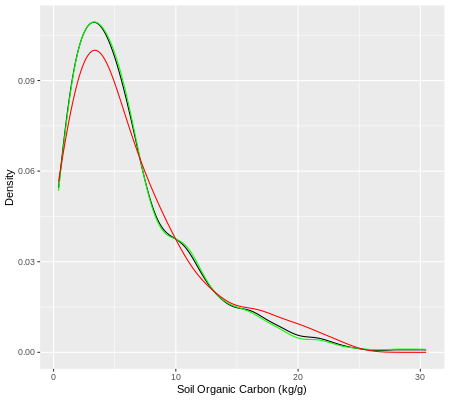

In [ ]:
%%R -w 450 -h 400 -u px
# set seed for reproducibility
set.seed(1245)
split <- initial_split(df, prop = 0.8, strata = SOC)
# training data
train <- split %>% training()
# Validation data
test <-  split %>% testing()

# Density plot all, train and test data
ggplot()+
  geom_density(data = df, aes(SOC))+
  geom_density(data = train, aes(SOC), color = "green")+
  geom_density(data = test, aes(SOC), color = "red") +
      xlab("Soil Organic Carbon (kg/g)") +
     ylab("Density")

### Feature Scaling

**Scale()** is a built-in R function that centers and/or scales the columns of a numeric matrix by default.

In [ ]:
%%R
train[-c(1, 11,12)] = scale(train[-c(1,11,12)])
test[-c(1, 11,12)] = scale(test[-c(1,11,12)])

## Random Forest Regression Model with randomForest package

The randomForest R package widely implements the random forest algorithm for building decision trees in machine learning. Random forests are an ensemble learning method that builds multiple decision trees and aggregates their predictions to make a final prediction. This can help to reduce overfitting and increase the accuracy of the model.

The randomForest package in R provides a simple interface for building random forests. It allows the user to specify the number of trees to build, the number of variables to sample at each split, and other hyperparameters. The package also includes functions for visualizing the random forest model, as well as methods for predicting new data and assessing model performance.

To get started with the randomForest package, you can install it from CRAN using the following code:

> install.packages("randomForest)



We can fit a random forest model using the **randomForest()** function, which implements Breiman's random forest algorithm (based on Breiman and Cutler's original Fortran code) for classification and regression. It can also be used in unsupervised mode for assessing proximities among data points.

The following parametrs will be used to fit a RF model:

-   ntree: 100, Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few time

-   mtry: 8, Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p/3)

-   nodesize: 5, Minimum size of terminal nodes. Setting this number larger causes smaller trees to be grown (and thus take less time). Note that the default values are different for classification (1) and regression (5).

-   maxnode: 5, Maximum number of terminal nodes trees in the forest can have. If not given, trees are grown to the maximum possible (subject to limits by nodesize). If set larger than maximum possible, a warning is issued.

-   keep.forest:  TRUE, If set to FALSE, the forest will not be retained in the output object. If xtest is given, defaults to FALSE.

-   importance: TRUE, Should importance of predictors be assessed




In [ ]:
%%R
# for reproducibility
set.seed(123)
# fit RF model
rf.fit <- randomForest(SOC ~ ., data=train,
                       ntree=500,
                       mtry = 8,
                       nodesize = 110,
                       #maxnode = 5,
                       importance=TRUE)
# model summary
print(rf.fit)


Call:
 randomForest(formula = SOC ~ ., data = train, ntree = 500, mtry = 8,      nodesize = 110, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 8

          Mean of squared residuals: 16.26973
                    % Var explained: 35.09


### Plot model error

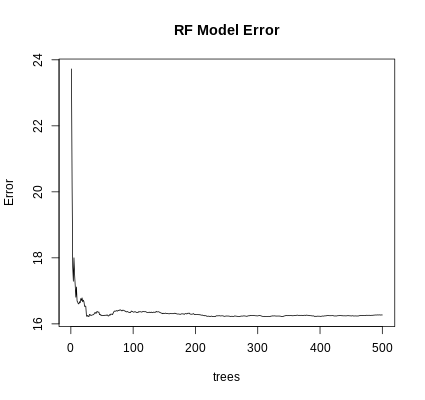

In [ ]:
%%R -w 425 -h 400 -u px
plot(rf.fit, main= "RF Model Error")

### Feature Importance

The feature importance in Random Forest is a measure of the influence of each feature on the model's accuracy. It is calculated by dividing the importance of each variable by its relative influence on the tree building process (i.e., whether the variable was chosen to split on) and the squared error (decreased across all trees) as a result of this. The significance of a feature in Random Forest is the sum of its importance across all decision trees.

There are different methods to calculate feature importance in Random Forest. The most commonly used methods are:

***Gini Importance***: It measures the total reduction of the Gini index, which is a measure of impurity, that is achieved by each feature. A higher reduction in the Gini index indicates a higher importance of the feature.

***Permutation Importance**: It measures the decrease in the accuracy of the model when a feature is randomly permuted. A higher decrease in accuracy indicates a higher importance of the feature.

***Mean Decrease Impurity***:
In a Random Forest algorithm, node purity is a measure of how homogeneous the group of data points at a particular node is with respect to their target labels. The algorithm builds a decision tree by recursively splitting the data into smaller subsets based on the features and their values, with the aim of maximizing the node purity at each level.It measures the average reduction in impurity over all decision trees in the Random Forest when a feature is used to split a node. A higher reduction in impurity indicates a higher importance of the feature.

In regression, the feature importance is calculated based on the mean decrease in impurity of the regression tree nodes or measures the variability of the target variable within the node. The impurity measure used for regression is the mean squared error (MSE) instead of the Gini index used in classification.

The importance of a feature is calculated by taking the total reduction in the MSE across all trees in the forest when the feature is used for splitting the nodes. A feature that reduces the MSE by a large amount is considered more important than a feature that reduces it by a smaller amount.

The feature importance scores can be normalized to add up to one. This allows for easy comparison of the relative importance of different features.

Once the feature importance is calculated, it can be used to select the most important features for the model or to interpret the model by understanding which features drive the predictions.

###  Feature Importance plot

**varImpPlot()** function create dotchart of variable importance as measured by a Random Forest

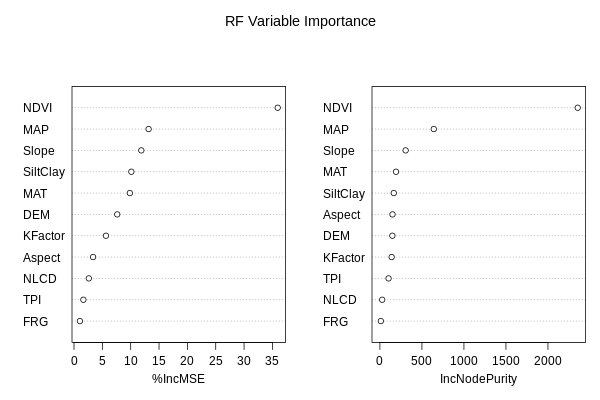

In [ ]:
%%R -w 600 -h 400 -u px
varImpPlot(rf.fit, main = "RF Variable Importance")

We can create a customized variable importance plot with ggplot2:

In [ ]:
%%R
# get variable importance from the model fit
ImpData <- as.data.frame(randomForest::importance(rf.fit))
ImpData$Var.Names <- row.names(ImpData)
ImpData

           %IncMSE IncNodePurity Var.Names
DEM       7.628828     148.12050       DEM
Slope    11.875047     306.06320     Slope
Aspect    3.362965     149.79050    Aspect
TPI       1.655997     102.85038       TPI
KFactor   5.635433     139.76361   KFactor
SiltClay 10.119163     165.20119  SiltClay
MAT       9.853377     191.75502       MAT
MAP      13.158569     641.19592       MAP
NDVI     35.930804    2354.00904      NDVI
NLCD      2.613661      27.05833      NLCD
FRG       1.042877      11.19863       FRG


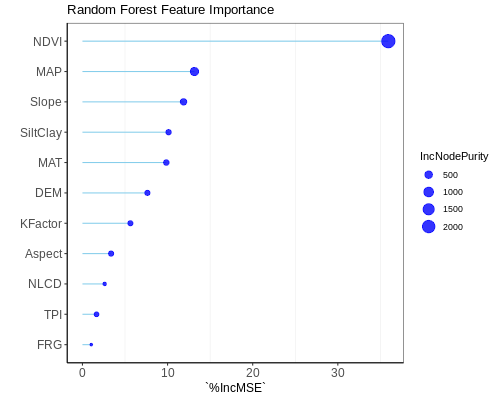

In [ ]:
%%R -w 500 -h 400 -u px
# Plot importance
ggplot(ImpData, aes(y=`%IncMSE`, x=reorder(Var.Names, +`%IncMSE`))) +
  geom_segment( aes(x=reorder(Var.Names, +`%IncMSE`), xend=Var.Names, y=0, yend=`%IncMSE`), color="skyblue") +
  geom_point(aes(size = IncNodePurity), color="blue", alpha=0.8) +
  ylab('`%IncMSE`') +
  xlab('')+
  theme_bw() +
  theme(axis.line = element_line(colour = "black"),
        panel.grid.major = element_blank(),
        axis.text.y=element_text(size=12),
        axis.text.x = element_text(size=12),
        axis.title.x = element_text(size=12),
        axis.title.y = element_text(size=12))+
  coord_flip()+
  ggtitle("Random Forest Feature Importance")

An alternative approach is to use the **vip** package, which provides ggplot2 plots. vip also provides an additional measure of variable importance based on partial dependence measures and is a common variable importance plotting framework for many machine learning models

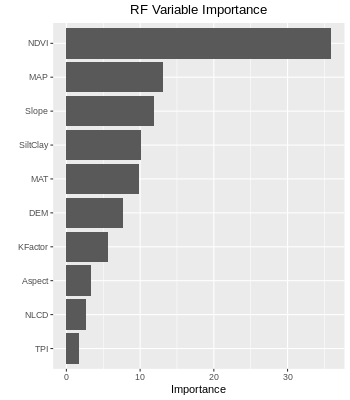

In [ ]:
%%R -w 350 -h 400 -u px
vip(rf.fit)+
  ggtitle("RF Variable Importance") +
  theme(plot.title = element_text(hjust = 0.5))



### Prediction

We use **predict()** function for prediction of test data using random forest.

In [ ]:
%%R
test$SOC.pred.rf = predict(rf.fit, newdata = test)

In [ ]:
%%R
RMSE<- Metrics::rmse(test$SOC, test$SOC.pred.rf)
RMSE

[1] 3.646275


In [ ]:
%%R
MAE<- Metrics::mae(test$SOC, test$SOC.pred.rf)
MAE

[1] 2.72598


`geom_smooth()` using formula = 'y ~ x'


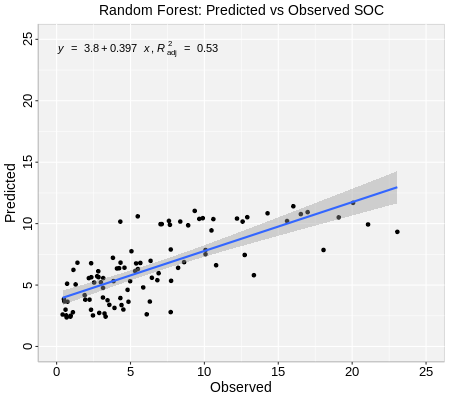

In [ ]:
%%R -w 450 -h 400 -u px

formula<-y~x

ggplot(test, aes(SOC,SOC.pred.rf)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Random Forest: Predicted vs Observed SOC") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## Random Forest with tidymodel

The [tidymodels](https://www.tidymodels.org/) is an R package library that aims to simplify and simplify the modeling and machine learning workflow in R. It is based on the “tidyverse” ecosystem, which includes well-known packages such as ggplot2, dplyr, and tidyr, which are well-known for their consistent and easy-to-understand syntax.

The tidymodels provides a comprehensive framework for building, tuning, and evaluating RF model while following the principles of the tidyverse.




### Load data and preprocesing

In [ ]:
%%R
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, Aspect, TPI, KFactor, SiltClay, MAT, MAP,NDVI, NLCD, FRG)
# convrt factor
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)
# Split data
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()
# Set 10 fold cross-validation data set
cv_folds <- vfold_cv(train, v = 5)

### Create Recipe

A recipe is a description of the steps to be applied to a data set in order to prepare it for data analysis. Before training the model, we can use a recipe to do some pre-processing required by the model.

In [ ]:
%%R
rf_recipe <-
  recipe(SOC ~ ., data = train) %>%
  step_zv(all_predictors()) %>%
  step_dummy(all_nominal()) %>%
  step_normalize(all_numeric_predictors())

### Specify tunable Hypermeters of Random Forest

Random Forest is an ensemble learning method that is highly flexible and has a large number of hyperparameters that can be tuned to optimize the performance of the model.

Some of the most important hyperparameters of a Random Forest model are:

1.  Number of trees: The number of trees in the forest. Increasing the number of trees generally improves the performance of the model, but also increases the computation time.

2.  Maximum depth of the trees: The maximum depth of the trees in the forest. Deeper trees can capture more complex relationships in the data, but can also lead to overfitting.

3.  Minimum number of samples required to split a node: The minimum number of samples required to split an internal node in the tree. Increasing this parameter can help to reduce overfitting.

4.  Minimum number of samples required to be at a leaf node: The minimum number of samples required to be at a leaf node. Increasing this parameter can help to reduce overfitting.

5.  Maximum number of features to consider for each split: The maximum number of features to consider when searching for the best split at each node. Restricting the number of features can help to reduce overfitting and improve generalization.

6.  Bootstrap samples: Whether to use bootstrap samples when building trees. Bootstrap samples can help to reduce overfitting and improve generalization.

7.  Random state: A seed value that is used to initialize the random number generator. This ensures that the results of the model are reproducible.

These hyperparameters can be tuned using various techniques, such as grid search or random search, to find the optimal combination for a particular dataset and problem.

We will create a model specification for a random forest where we will tune tree (numbrr of tree), mtry (the number of predictors to sample at each split) and min_n (the number of observations needed to keep splitting nodes). Will will use [ranger](https://cran.r-project.org/web/packages/ranger/index.html) package that provides a fast implementation of the Random Forest algorithm for classification and regression problems. It is designed to handle large datasets with many features, and offers several features that make it a popular choice for machine learning tasks.

In [ ]:
%%R
rf_model <- rand_forest(
  mtry = tune(),
  trees = tune(),
  min_n = tune()
  ) %>%
  set_mode("regression") %>%
  set_engine("ranger")

rf_model

Random Forest Model Specification (regression)

Main Arguments:
  mtry = tune()
  trees = tune()
  min_n = tune()

Computational engine: ranger 



### Define workflow

In [ ]:
%%R
rf_wf <- workflow() %>%
  add_recipe(rf_recipe) %>%
  add_model(rf_model)

### Define possible grid parameter

We use grid_regular() function of dials package (installed with tidymodesl) to create grids of tuning parameters

In [ ]:
%%R
rf_grid <- grid_regular(
  trees(range = c(20, 100)),
  mtry(range = c(10, 20)),
  min_n(range = c(1, 5)),
  levels = 5
)

rf_grid

# A tibble: 125 × 3
   trees  mtry min_n
   <int> <int> <int>
 1    20    10     1
 2    40    10     1
 3    60    10     1
 4    80    10     1
 5   100    10     1
 6    20    12     1
 7    40    12     1
 8    60    12     1
 9    80    12     1
10   100    12     1
# ℹ 115 more rows
# ℹ Use `print(n = ...)` to see more rows


### Hyperparameters tunning

Now we will fit the models with all the possible parameter values on all our resampled (cv.fold) datasets. tune_grid() of tune package (installed with tidymodels) computes a set of performance metrics (e.g. accuracy or RMSE) for a pre-defined set of tuning parameters that correspond to a model or recipe across one or more resamples of the data.

We will use parallel processing to run RF model faster, since the different parts of the grid are independent. Let's use grid = 20 to choose 20 grid points automatically.

tune_grid() computes a set of performance metrics (e.g. accuracy or RMSE) for a pre-defined set of tuning parameters that correspond to a model or recipe across one or more resamples of the data.

In [ ]:
%%R
# Set 10 fold cross-validation data set
cv_folds <- vfold_cv(train, v = 10)

In [ ]:
%%R
set.seed(345)
rf_tune <- tune_grid(
  rf_wf,
  resamples = cv_folds,
  grid = rf_grid,
)

rf_tune

In [ ]:
%%R
collect_metrics(rf_tune)

# A tibble: 250 × 9
    mtry trees min_n .metric .estimator  mean     n std_err .config             
   <int> <int> <int> <chr>   <chr>      <dbl> <int>   <dbl> <chr>               
 1    10    20     1 rmse    standard   3.90     10  0.262  Preprocessor1_Model…
 2    10    20     1 rsq     standard   0.401    10  0.0386 Preprocessor1_Model…
 3    10    40     1 rmse    standard   3.93     10  0.280  Preprocessor1_Model…
 4    10    40     1 rsq     standard   0.392    10  0.0493 Preprocessor1_Model…
 5    10    60     1 rmse    standard   3.88     10  0.260  Preprocessor1_Model…
 6    10    60     1 rsq     standard   0.399    10  0.0459 Preprocessor1_Model…
 7    10    80     1 rmse    standard   3.91     10  0.267  Preprocessor1_Model…
 8    10    80     1 rsq     standard   0.400    10  0.0479 Preprocessor1_Model…
 9    10   100     1 rmse    standard   3.89     10  0.258  Preprocessor1_Model…
10    10   100     1 rsq     standard   0.402    10  0.0472 Preprocessor1_Model…
# ℹ 240 

We can plot RMSE:

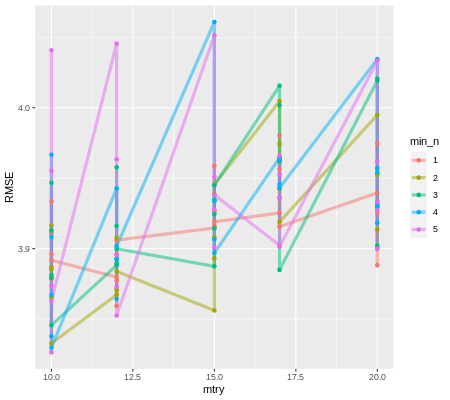

In [ ]:
%%R -w 450 -h 400 -u px
rf_tune %>%
  collect_metrics() %>%
  filter(.metric == "rmse") %>%
  mutate(min_n = factor(min_n)) %>%
  ggplot(aes(mtry, mean, color = min_n)) +
  geom_line(alpha = 0.5, size = 1.5) +
  geom_point() +
  labs(y = "RMSE")

### The best RF model

In [ ]:
%%R
best_rmse <- select_best(rf_tune, "rmse")

rf_final <- finalize_model(
  rf_model,
  best_rmse
)

rf_final

Random Forest Model Specification (regression)

Main Arguments:
  mtry = 10
  trees = 80
  min_n = 5

Computational engine: ranger 



We can either fit final_tree to training data using fit() or to the testing/training split using last_fit(), which will give us some other results along with the fitted output.

In [ ]:
%%R
final_fit <- fit(rf_final, SOC ~ .,train)

### Prediction

In [ ]:
%%R
test$SOC.pred_ranger = predict(final_fit,test)

In [ ]:
%%R
RMSE<- Metrics::rmse(test$SOC, test$SOC.pred_ranger$.pred)
RMSE

[1] 3.542123


### 1:1 Plot Predicted vs Observed values

`geom_smooth()` using formula = 'y ~ x'


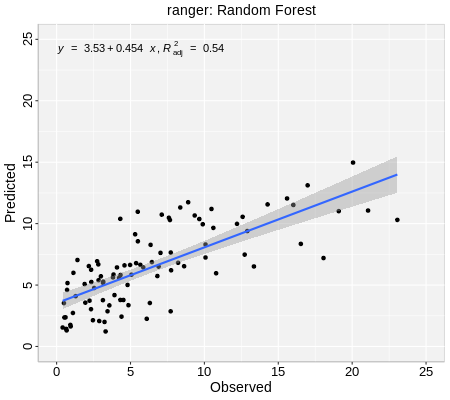

In [ ]:
%%R -w 450 -h 400 -u px
formula<-y~x

ggplot(test, aes(SOC,SOC.pred_ranger$.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("ranger: Random Forest") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Variable importance plots

**vip()** function can plot variable importance scores for the predictors in a model.

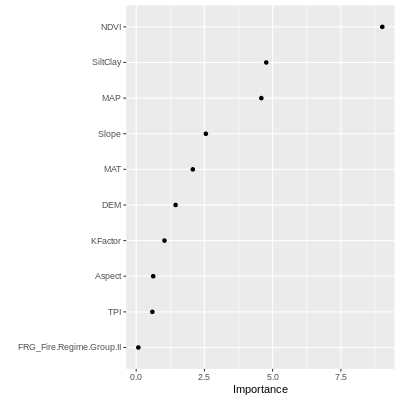

In [ ]:
%%R -w 400 -h 400 -u px
rf_prep <- prep(rf_recipe)
juiced <- juice(rf_prep)

rf_final %>%
  set_engine("ranger", importance = "permutation") %>%
  fit(SOC ~ .,
    data = juice(rf_prep)
  ) %>%
  vip(geom = "point")+
     ggtitle("ranger: RF Variable Importance") +
     theme(plot.title = element_text(hjust = 0.5))

## Random Forest with h20

RF in h20 is also referred to as a distributed random forest (DRF), which is a parallel implementation of Random Forest. In a DRF, individual trees are trained on a subset of the data rows and columns. This randomization helps to minimize overfitting and enhance model accuracy and stability. The individual tree predictions are then combined to form a final prediction.

DRF also offers a range of hyperparameter values that can be adjusted to improve the model's performance, he number of trees, the depth of the trees, and the sampling rate for each tree. The algorithm can also be used to automatically fine-tune hyperparameters using either grid or random search.

Overall, DRF in H2O provides a powerful and scalable tool for building accurate and robust predictive models on large datasets by distributing the computation across a cluster of machines, DRF can handle datasets that would be too large to process on a single machine, making it a valuable tool for big data applications.

### Import h20

In [ ]:
%%R
library(h2o)
h2o.init()
#disable progress bar for RMarkdown
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

### Load and process data

In [ ]:
%%R
# load data
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, Aspect, TPI, KFactor, SiltClay, MAT, MAP,NDVI, NLCD, FRG)
# convrt factor
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)
# Split data
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()
# Scale data
train[-c(1, 11,12)] = scale(train[-c(1,11,12)])
test[-c(1, 11,12)] = scale(test[-c(1,11,12)])

Rows: 467 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD, FRG
dbl (15): ID, FIPS, STATE_ID, Longitude, Latitude, SOC, DEM, Aspect, Slope, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Import data to h2o cluster

In [ ]:
%%R
h_df=as.h2o(df)
h_train = as.h2o(train)
h_test = as.h2o(test)

In [ ]:
%%R
CV.xy<- as.data.frame(h_train)
test.xy<- as.data.frame(h_test)

### Define response and predictors

In [ ]:
%%R
y <- "SOC"
x <- setdiff(names(h_df), y)

### Fit DRF model

First we will fit a h2o DRF model with lfollowing parameters:

*  ntrees = 200,  Number of trees. Defaults to 50.

* max_depth = 25, Maximum tree depth (0 for unlimited). Defaults to 20.

* sample_rate = 0.8, Row sample rate per tree (from 0.0 to 1.0) Defaults to 0.632.

*  stopping_rounds = 2, Early stopping based on convergence of stopping_metric. Stop if simple moving average of length k of the stopping_metric does not improve for k:=stopping_rounds scoring events (0 to disable) Defaults to 0.

* stopping_metric="RMSE", Metric to use for early stopping (AUTO: logloss for classification, deviance for regression and anomaly_score for Isolation Forest). Note that custom and custom_increasing can only be used in GBM and DRF with the Python client. Must be one of: "AUTO", "deviance", "logloss", "MSE", "RMSE", "MAE", "RMSLE", "AUC", "AUCPR", "lift_top_group", "misclassification", "mean_per_class_error", "custom", "custom_increasing". Defaults to AUTO.

*  nfolds = 10, Number of folds for K-fold cross-validation (0 to disable or >= 2). Defaults to 0.

* keep_cross_validation_models =TRUE, Logical. Whether to keep the cross-validation models. Defaults to TRUE.

* keep_cross_validation_predictions = TRUR, Logical. Whether to keep the predictions of the cross-validation models. Defaults to FALSE.

#### Fit model

In [ ]:
%%R
drf_h2o <- h2o.randomForest(
  training_frame = h_train,
  # validation_frame = valid,
  x=x,
  y=y,
  model_id = "RF_MODEL_IDs",
  ntrees = 200,
  max_depth =25,
  sample_rate = 0.8,
  stopping_rounds = 2,
  stopping_metric = "RMSE",
  nfolds = 10,
  keep_cross_validation_models = TRUE,
  keep_cross_validation_predictions =TRUE,
  seed = 1000000)


#### Model summary

In [ ]:
%%R
# model summary
summary(drf_h2o)

Model Details:

H2ORegressionModel: drf
Model Key:  RF_MODEL_IDs 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              12                       12               44724        16
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        22   18.41667        280        305   292.16666

H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  22.11228
RMSE:  4.70237
MAE:  3.290161
RMSLE:  0.5888373
Mean Residual Deviance :  22.11228



H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  16.49581
RMSE:  4.061503
MAE:  2.86872
RMSLE:  0.5277316
Mean Residual Deviance :  16.49581


Cross-Validation Metrics Summary: 
                            mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                     2.938290 0.537295   3.744029   2.929060 

#### Model performance

In [ ]:
%%R
# training performance
h2o.performance(drf_h2o, h_train)

H2ORegressionMetrics: drf

MSE:  1.016003
RMSE:  1.00797
MAE:  0.6409741
RMSLE:  0.1456079
Mean Residual Deviance :  1.016003



In [ ]:
%%R
# CV-performance
h2o.performance(drf_h2o, xval=TRUE)

H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  16.49581
RMSE:  4.061503
MAE:  2.86872
RMSLE:  0.5277316
Mean Residual Deviance :  16.49581



In [ ]:
%%R
# test performance
h2o.performance(drf_h2o, h_test)

H2ORegressionMetrics: drf

MSE:  12.266
RMSE:  3.502285
MAE:  2.608164
RMSLE:  0.5240374
Mean Residual Deviance :  12.266



#### Prediction

In [ ]:
%%R
pred.drf <- as.data.frame(h2o.predict(object = drf_h2o, newdata = h_test))
test.xy$DRF_SOC<-pred.drf$predict

`geom_smooth()` using formula = 'y ~ x'


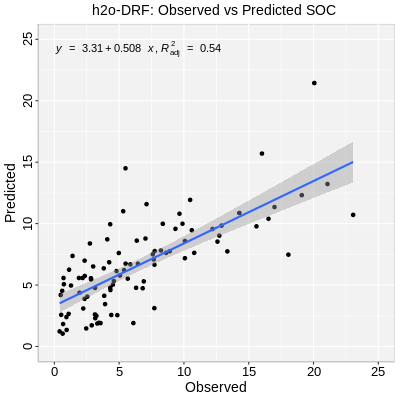

In [ ]:
%%R -w 400 -h 400 -u px
formula<-y~x

ggplot(test.xy, aes(SOC,DRF_SOC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("h2o-DRF: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Fit the Best RF model with hyperparameter tunning

H2O Grid Search is a hyperparameter optimization technique used in the H2O machine learning framework. It involves a systematic search through a specified subset of hyperparameters of a machine learning model to find the optimal combination of hyperparameters that maximizes the performance metric of interest, such as RMSE or AUC.

In a grid search, a set of hyperparameters is defined, and a range of values is specified for each hyperparameter. The grid search algorithm then systematically evaluates all possible combinations of hyperparameter values, training and evaluating a model for each combination, and selecting the combination that performs the best on the validation set.

H2O Grid Search can be used with various machine learning models, including generalized linear models, random forest, gradient boosting machines, and deep learning models. It can help improve the performance of machine learning models by fine-tuning their hyperparameters and reducing overfitting.

* ntrees :  number of trees
* mtries:  number of variables randomly sampled as candidates at each split.
* max_depth:  Maximum tree depth (0 for unlimited). Defaults to 20.
* min_rows:   Fewest allowed (weighted) observations in a leaf.
* sample_rate: Row sample rate per tree (from 0.0 to 1.0) Defaults to 0.632.

**Search Criteria** is a parameter that can be used to specify the stopping criteria for a grid search or a random grid search. By setting the search_criteria parameter, you can control the runtime and complexity of the grid search, and avoid overfitting by early stopping based on the validation metric.

search_criteria is a dictionary that contains one or more of the following parameters:

**strategy**: H2O supports two types of grid search -- traditional (or "cartesian") grid search and random grid search. In a cartesian grid search, users specify a set of values for each hyperparameter that they want to search over, and H2O will train a model for every combination of the hyperparameter values. This means that if you have three hyperparameters and you specify 5, 10 and 2 values for each, your grid will contain a total of 5*10*2 = 100 models.

**max_models**: The maximum number of models to build. The default is NULL, which means to build all possible models.

**max_runtime_secs**: The maximum amount of time in seconds that the grid search can run. The default is NULL, which means to run until the other stopping criteria are met.

**stopping_rounds**: The number of consecutive builds without an improvement in the validation metric that triggers early stopping. The default is 0, which means to disable early stopping.

**stopping_tolerance**: The relative tolerance for the metric-based stopping criterion. The default is 0.001.

**stopping_metric**: The metric to use for the metric-based stopping criterion. The default is "AUTO", which means to use the default metric for the specified problem type.

RandomDiscrete grid search involves randomly sampling hyperparameters from a predefined set of discrete values and evaluating the performance of the model with each combination of hyperparameters.

This method is useful when the search space for hyperparameters is large and discrete, meaning that the values are distinct and finite. In contrast to a regular grid search, which evaluates all possible combinations of hyperparameters, a random search selects a random subset of hyperparameters to evaluate.

The advantage of using RandomDiscrete grid search is that it can be more efficient than a regular grid search, especially when many of the hyperparameters are not critical to the performance of the model. It can also help to prevent overfitting, as it encourages the exploration of a wider range of hyperparameters.

For example, to specify a maximum of 20 models to build and a maximum runtime of 600 seconds for a grid search, you can set the search_criteria parameter as follows:

In [ ]:
%%R
# Hyperparameter
RF_hyper_params <- list(
  ntrees      = seq(10, 500, by = 20),
  mtries      = seq(10, 40, by = 10),
  max_depth   = seq(20, 40, by = 5),
  min_rows    = seq(1, 5, by = 1),
  sample_rate = c(0.5, 0.6, 0.7, 0.8, 0.9))
# Search criteria
RF_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 200,
                        max_runtime_secs = 900,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 42)
RF_hyper_params

$ntrees
 [1]  10  30  50  70  90 110 130 150 170 190 210 230 250 270 290 310 330 350 370
[20] 390 410 430 450 470 490

$mtries
[1] 10 20 30 40

$max_depth
[1] 20 25 30 35 40

$min_rows
[1] 1 2 3 4 5

$sample_rate
[1] 0.5 0.6 0.7 0.8 0.9



### Fit DRF with Grid Search

h2o.grid() provides a set of functions to launch a grid search and get its results:


In [ ]:
%%R
rf_grid <- h2o.grid(
                  algorithm="randomForest",
                  grid_id = "RF_grid_IDs",
                  x = x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  stopping_metric = "RMSE",
                  #fold_assignment ="Stratified",
                  nfolds=10,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = RF_hyper_params,
                  search_criteria = RF_search_criteria,
                  seed = 42)

In [ ]:
%%R
# number of RF models
length(rf_grid@model_ids)

[1] 27


### The best DRF model

In [ ]:
%%R
DRF_get_grid <- h2o.getGrid("RF_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)
# Get the best RF model
best_DRF <- h2o.getModel(DRF_get_grid@model_ids[[1]])
best_DRF

Model Details:

H2ORegressionModel: drf
Model ID:  RF_grid_IDs_model_84 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1             270                      270              144141         7
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        14    9.42593         32         43    37.67037


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  15.94351
RMSE:  3.992933
MAE:  2.806285
RMSLE:  0.5039699
Mean Residual Deviance :  15.94351



H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  16.315
RMSE:  4.039183
MAE:  2.866356
RMSLE:  0.5111034
Mean Residual Deviance :  16.315


Cross-Validation Metrics Summary: 
                            mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                     2.860874 0.449045   2.267499   3.1

### Model performance

In [ ]:
%%R
# training performance
h2o.performance(best_DRF, h_train)

H2ORegressionMetrics: drf

MSE:  7.687139
RMSE:  2.772569
MAE:  1.908002
RMSLE:  0.3592962
Mean Residual Deviance :  7.687139



In [ ]:
%%R
# CV-performance
h2o.performance(best_DRF, xval=TRUE)

H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  16.315
RMSE:  4.039183
MAE:  2.866356
RMSLE:  0.5111034
Mean Residual Deviance :  16.315



In [ ]:
%%R
# test performance
h2o.performance(best_DRF, h_test)

H2ORegressionMetrics: drf

MSE:  12.5432
RMSE:  3.541639
MAE:  2.565853
RMSLE:  0.497662
Mean Residual Deviance :  12.5432



### Prediction

In [ ]:
%%R
test.pred.DRF_best<-as.data.frame(h2o.predict(object = best_DRF, newdata = h_test))
test.xy$best_DRF_SOC<-test.pred.DRF_best$predict

#### 1:1 Plot Observed vs Predicted values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


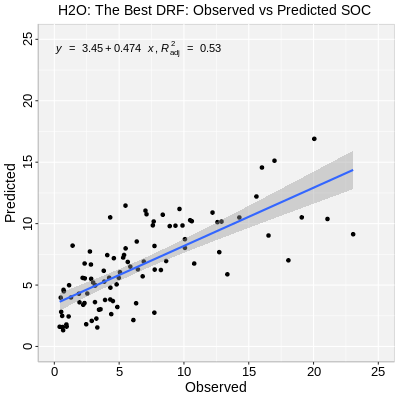

In [ ]:
%%R -w 400 -h 400 -u px
formula<-y~x

ggplot(test.xy, aes(SOC,best_DRF_SOC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("H2O: The Best DRF: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Model Explainability

Model explainability refers to the ability to understand and interpret the decisions made by a machine learning model. In other words, it is the ability to explain how a model arrives at its predictions or classifications.

Explainability is particularly important in applications where decisions made by the model have significant real-world consequences, such as in healthcare, finance, and legal fields. It is also important for regulatory compliance, where models must be auditable and transparent.

The h2o.explain() function generates a list of explanations -- individual units of explanation such as a Partial Dependence plot or a Variable Importance plot. Most of the explanations are visual -- these plots can also be created by individual utility functions outside the h2o.explain() function.

#### Variable importance.

In [ ]:
%%R
h2o.varimp(best_DRF)

Variable Importances: 
   variable relative_importance scaled_importance percentage
1      NDVI       731981.187500          1.000000   0.569060
2     Slope        96032.351562          0.131195   0.074658
3       MAP        95423.500000          0.130363   0.074185
4  SiltClay        71684.015625          0.097931   0.055729
5   KFactor        65044.726562          0.088861   0.050567
6    Aspect        58552.929688          0.079992   0.045520
7       MAT        57641.214844          0.078747   0.044812
8       TPI        50425.214844          0.068889   0.039202
9       DEM        36839.414062          0.050328   0.028640
10      FRG        16002.115234          0.021861   0.012440
11     NLCD         6672.872070          0.009116   0.005188


#### Variable Importance Plot

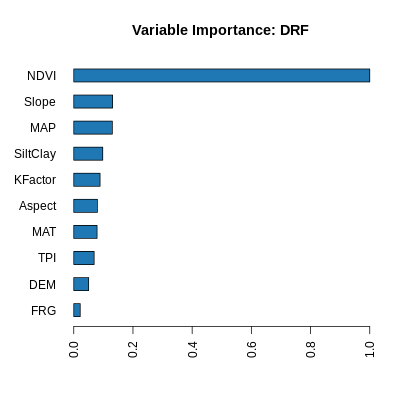

In [ ]:
%%R -w 400 -h 400 -u px
h2o.varimp_plot(best_DRF)

### SHAP Local Explanation

SHAP (SHapley Additive exPlanations) values are a method for explaining the output of any machine learning model. SHAP values provide a way to attribute the prediction of an individual feature to its contribution to the final prediction, taking into account the interaction with other features in the model.

SHAP values are based on the Shapley value from cooperative game theory, which attributes a value to each player in a game based on their contribution to the game's outcome. In the context of machine learning, the "players" are the input features of the model, and the "game" is the prediction made by the model.

The SHAP value for a particular feature is calculated by comparing the model's prediction for a specific data point with and without that feature's value included. This comparison is done for all possible subsets of features, and the contributions of each feature are averaged using the Shapley value formula.

The resulting SHAP values represent the contribution of each feature to the final prediction, with positive values indicating a positive impact on the prediction and negative values indicating a negative impact.

SHAP values can be used to provide insights into how a model is making its predictions and to identify which features are most important for a particular prediction. They can also be used to identify bias in a model and to ensure that the model is making predictions fairly and transparently.

H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

In [ ]:
%%R -w 450 -h 500 -u px
h2o.shap_summary_plot(best_DRF, h_train)

UsageError: Cell magic `%%R` not found.


### Partial Dependence (PD) Plots

A partial dependence plot (PDP) is a graphical tool for understanding the relationship between a particular input feature and the output of a machine learning model.

A PDP shows the marginal effect of a single feature on the predicted outcome while holding all other features at a fixed value or their average value. The PDP can help to visualize the shape and direction of the relationship between the feature and the output, and can also help to identify any non-linearities or interactions between the feature and other features in the model.

To create a PDP, the value of the feature of interest is varied over its range, and the model's predicted output is recorded for each value. The resulting data is then plotted on a graph, with the feature's value on the x-axis and the predicted output on the y-axis.

PDPs can be used to gain insights into how a model is making its predictions and to identify which features are most important for the model's output. They can also be used to identify potential biases in the model or to detect interactions between features that may be difficult to detect using other methods.

In [ ]:
%%R -w 450 -h 400 -u px
h2o.pd_multi_plot(best_DRF, h_train, "NDVI")

UsageError: Cell magic `%%R` not found.


#### Residual Analysis

Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable

In [ ]:
%%R -w 450 -h 400 -u px
h2o.residual_analysis_plot(best_DRF, h_train)

UsageError: Cell magic `%%R` not found.


## Further Reading

1.  [Random Forest in R](https://www.r-bloggers.com/2021/04/random-forest-in-r/)

2.  [Tuning random forest hyperparameters with #TidyTuesday trees data](https://juliasilge.com/blog/sf-trees-random-tuning/)

3.  [GBM_RandomForest_Example.R](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/gbm-randomforest/GBM_RandomForest_Example.R)

4.  [Training and Turning Parameters for Random Forest Using h2o Package](https://rpubs.com/chidungkt/449576)

### YouTube Video

1.  Visual Guide to Random Forest

{{< video https://www.youtube.com/watch?v=cIbj0WuK41w&t=224s >}}

Source: [Econoscent](https://www.youtube.com/@Econoscent)

2.  StatQuest: Random Forests Part 1 - Building, Using and Evaluating

{{< video https://www.youtube.com/watch?v=J4Wdy0Wc_xQ >}}

Source: [StatQuest with Josh Starme](https://www.youtube.com/@statquest)